# 07. Case study: non-gaussian noise

In [1]:
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression

Сначала немного вспомним, какие вероятностные предположнеия мы делали в обычной регрессии.

Собственно, линейная зависимость $\mathbf{y}$ от $\mathbf{x}$:

$$y(\mathbf{x}, \mathbf{w}) = \sum_{j=0}^{M-1}{w_j x_j} = \mathbf{w}^T \mathbf{x} \tag{1}$$

Далее, говорим что в настоящих данных метки с шумом:
$$
t = y(\mathbf{x}, \mathbf{w}) + \epsilon \tag{2}
$$

Который (важно):
1. Имеет нормальное распределение с нулевым средним
2. Гомоскедастичен (то есть, не зависит от x)
3. Независим в совокупности (то есть, шум в каждой точке данных - множество независимых в совокупности с.в.)

Правдоподобие одной точки данных:
$$
p(t \lvert \mathbf{x}, \mathbf{w}, \beta) = 
\mathcal{N}(t \lvert y(\mathbf{x}, \mathbf{w}), \beta^{-1}) =
\sqrt{\beta \over {2 \pi}} \exp\left(-{\beta \over 2} (t - y(\mathbf{x}, \mathbf{w}))^2 \right) \tag{3}
$$

Наконец, полное правдоподобие:

$$
p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) = 
\prod_{i=1}^{N}{\mathcal{N}(t_i \lvert \mathbf{w}^T \mathbf{x_i}, \beta^{-1})} \tag{4}
$$



Помните полиномиальную регрессию с лекций, где в качестве $X$ мы подставляли степени одной-единственной независимой переменной $x$? Так вот, в литературе такой трюк называется **design matrix**, и конечно вместо степеней можно подставлять абсолютно что угодо.

$$
\boldsymbol\Phi = 
\begin{pmatrix}
\phi_0(\mathbf{x}_1) &  \phi_1(\mathbf{x}_1) & \cdots & \phi_{M-1}(\mathbf{x}_1) \\ 
\phi_0(\mathbf{x}_2) &  \phi_1(\mathbf{x}_2) & \cdots & \phi_{M-1}(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(\mathbf{x}_N) &  \phi_1(\mathbf{x}_N) & \cdots & \phi_{M-1}(\mathbf{x}_N)
\end{pmatrix} \tag{7}
$$


В большинстве случаев предположение о том, что шум имеет нормальное распределение - абсолютно логичное, благодаря ЦПТ. Но там, где условия ЦПТ нарушаются (какие там условия, кстати? а кто может привести пример?), возникают другие респределения. 

Например, экспоненциальное распределение - это распределение интервалов между равномерно распределенными с.в. Так что если, например, вы измеряете время какого-то процесса, и оно замеряется с задержкой - вы получите экспоненциальный шум. В жизни экспоненциальное респределение имеют, например, паузы между щелчками счетчика Гейгера.

# Синтетические данные

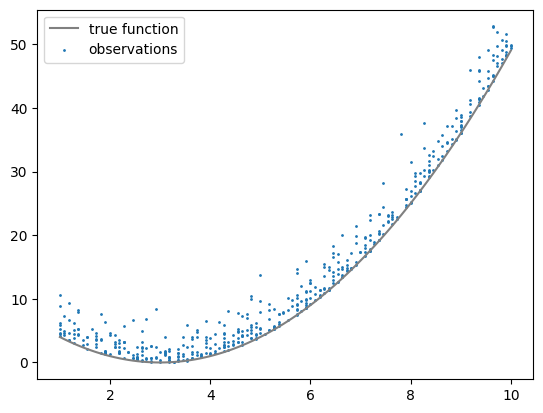

In [3]:
def f_true(x):
    return (x - 3) ** 2


x = np.linspace(1, 10, 100)
x_observed = np.random.choice(x, size=500, replace=True)
y_observed = f_true(x_observed) + np.random.exponential(2.0, len(x_observed))

plt.plot(x, f_true(x), c="grey", label="true function")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()

# Обычная регресссия

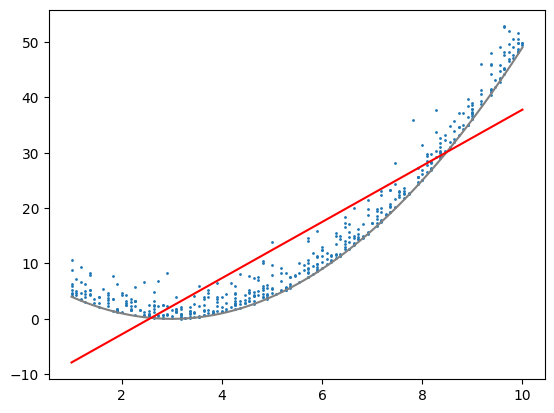

In [7]:
regr = LinearRegression()
regr.fit(x_observed[:, None], y_observed)
y_pred = regr.predict(x[:, None])

plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, y_pred, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")

# Обычная регресссия + полиномиальный базис

In [11]:
def get_design(x):
    return np.concatenate([x[:, None], x[:, None] ** 2], axis=1)


get_design(np.array([1, 2, 3]))

array([[1, 1],
       [2, 4],
       [3, 9]])

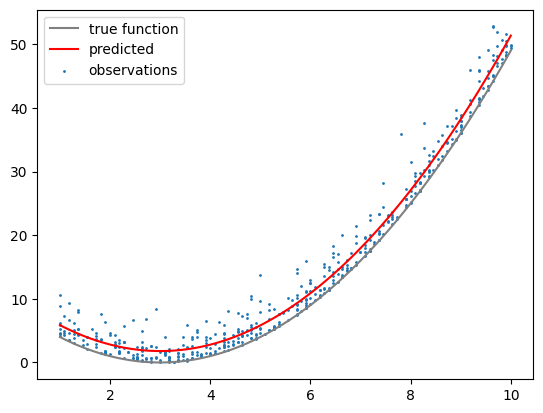

In [12]:
regr = LinearRegression()
regr.fit(get_design(x_observed), y_observed)
y_pred = regr.predict(get_design(x))

plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, y_pred, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()

In [13]:
regr.intercept_, regr.coef_

(np.float64(10.949438912644856), array([-6.0907604 ,  1.01317134]))

# Линейная регрессия с экспоненциальным распределением шума

In [14]:
from tqdm.notebook import tqdm


def log_likelihood(X, y, W, _lambda=1):
    """
    PDF: lambda * exp (-lambda * x)

    :param X_data: observable features with (bias term at first coordinate)
                    expected shape: (n_samples, n_features + 1)
    :param y: observable target
                    expected shape: (n_samples)
    :param W: weight matrix (with bias term at first coordinate):
                    expexted_shape: (n_features + 1, )
    """
    preds = X @ W
    residuals = y - preds
    if (residuals < 0).any():
        return -99999.0
    log_likelihood = -(residuals).sum()
    return log_likelihood


def add_bias_to_features(X):
    X = np.concatenate([np.ones_like(X)[:, 0:1], X], axis=-1)
    return X


X = add_bias_to_features(x_observed[:, None])

print("Negative Log Likelihood:", -log_likelihood(X, y_observed, np.zeros(2)))

Negative Log Likelihood: 7294.2736813765405


Как вы наверное помните с лекций, максимизация полного правдоподобия линейной модели **с нормальным шумом** - это в точности минимизация суммы квадратов отклонений, а еще для нее можно провести честный байесовский вывод. 

С другим распроеделением шума, оба утверждения неверны. Во-первых, оптимизировать надо иначе (почему?), во-вторых вывести ничего не выйдет.

Negative Log Likelihood: 4310.467137347004
Optimum: [-21.1795209    5.00081177]


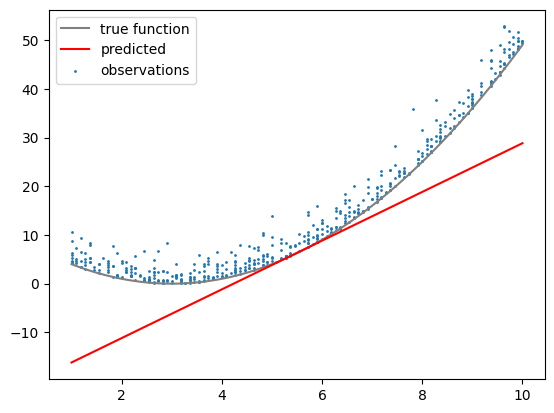

In [16]:
W = np.zeros(X.shape[-1]).T

slices = [slice(-30, 30, 0.1) for _ in W]

W_optimal, likelihood, grid_values, grid = scipy.optimize.brute(
    lambda W: -log_likelihood(X, y_observed, np.array(W)),
    ranges=slices,
    full_output=True,
)


print("Negative Log Likelihood:", likelihood)
print("Optimum:", W_optimal)
plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, add_bias_to_features(x[:, None]) @ W_optimal, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()

In [20]:
grid_values, grid = grid, grid_values

/home/arabella/Downloads/sync/work/teaching/teaching_venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


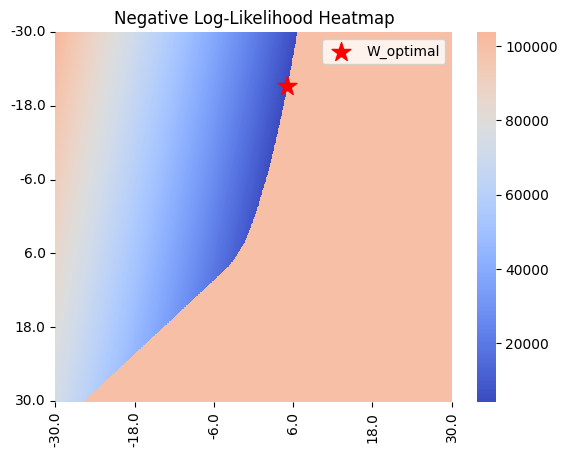

In [21]:
ax = sns.heatmap(grid_values, cmap="coolwarm", center=grid_values.mean())
x_ticks = np.arange(slices[0].start, slices[0].stop, slices[0].step)
y_ticks = np.arange(slices[1].start, slices[1].stop, slices[1].step)
ax.set_xticks(np.linspace(0, len(x_ticks) - 1, num=6))  # Adjust the number of ticks
ax.set_yticks(np.linspace(0, len(y_ticks) - 1, num=6))
ax.set_xticklabels(
    [f"{tick:.1f}" for tick in np.linspace(slices[0].start, slices[0].stop, num=6)]
)
ax.set_yticklabels(
    [f"{tick:.1f}" for tick in np.linspace(slices[1].start, slices[1].stop, num=6)]
)
ax.set_title("Negative Log-Likelihood Heatmap")

y_idx = int((W_optimal[0] - slices[0].start) / slices[0].step)
x_idx = int((W_optimal[1] - slices[1].start) / slices[1].step)
plt.scatter(x_idx, y_idx, marker="*", color="red", s=200, label="W_optimal")
plt.legend()
plt.show()

# Экспоненциальный шум + полиномиальный базис

In [22]:
X = add_bias_to_features(get_design(x_observed))
W = np.ones(X.shape[-1]).T

slices = [slice(-30, 30, 0.1) for _ in W]

W_optimal, likelihood, grid_values, grid = scipy.optimize.brute(
    lambda W: -log_likelihood(X, y_observed, np.array(W)),
    ranges=slices,
    full_output=True,
)


print("Negative Log Likelihood:", likelihood)


KeyboardInterrupt



In [ ]:
print("Optimum:", W_optimal)
plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, add_bias_to_features(get_design(x)) @ W_optimal, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()

# Case study: Robust linear regression

Предыдущий пример был интересный концептуально, но на самом-то деле не очень практичный. Теперь более практичный сюжет:



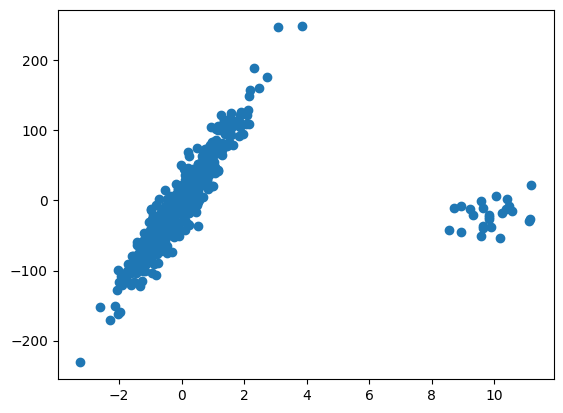

In [42]:
# снова сгенерированные даные

N_SAMPLES = 500
N_OUTLIERS = 25

X, y, coef = datasets.make_regression(
    n_samples=N_SAMPLES,
    n_features=1,
    n_informative=1,
    noise=20,
    coef=True,
    random_state=42,
)

coef_list = [["original_coef", float(coef)]]

# add outliers
np.random.seed(42)
X[:N_OUTLIERS] = 10 + 0.75 * np.random.normal(size=(N_OUTLIERS, 1))
y[:N_OUTLIERS] = -15 + 20 * np.random.normal(size=N_OUTLIERS)

plt.scatter(X, y);

Казалось бы, есть линейная модель, есть данные которые явно имеют линейную природу. Ну добавили к ним 5% каких-то выбросов, что может пойти не так?

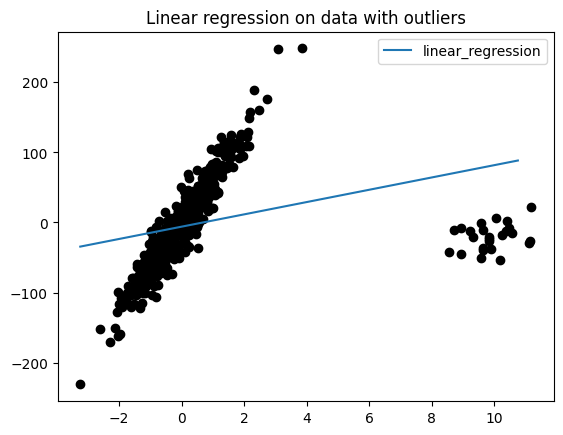

In [43]:
lr = LinearRegression().fit(X, y)
coef_list.append(["linear_regression", lr.coef_[0]])

plotline_X = np.arange(X.min(), X.max()).reshape(-1, 1)
fit_df = pd.DataFrame(
    index=plotline_X.flatten(), data={"linear_regression": lr.predict(plotline_X)}
)

fix, ax = plt.subplots()
fit_df.plot(ax=ax)
plt.scatter(X, y, c="k")
plt.title("Linear regression on data with outliers");

### И что теперь делать?

Есть целое семейство линейных моделей, которые менее чувствительны к выбросам. Про какие-то из них (Huber, RANSAC) мы поговорим через одно занятие, а сегодня придумаем что-нибудь на коленке. Что предложите?

In [44]:
X = add_bias_to_features(X)
X.shape, y.shape

((500, 2), (500,))

In [45]:
from scipy.stats import t


def log_likelihood(X, y, w, df=1):
    preds = X @ w
    residuals = y - preds
    return t(df).logpdf(residuals).sum()


log_likelihood(X, y, np.array([0, 100]))

np.float64(-3934.8626178274426)

In [50]:
df = 1
res = scipy.optimize.minimize(
    lambda w: -log_likelihood(X, y, np.array(w)), np.array([0, 0])
)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4041.9559736029323
        x: [-4.604e+00 -7.334e-01]
      nit: 14
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.227e-02 -3.945e-03]
            [-3.945e-03  3.076e-03]]
     nfev: 126
     njev: 42

In [47]:
fit_df

,linear_regression
-3.241267,-34.417132
-2.241267,-25.644817
-1.241267,-16.872502
-0.241267,-8.100187
0.758733,0.672128
1.758733,9.444443
2.758733,18.216758
3.758733,26.989073
4.758733,35.761388
5.758733,44.533703


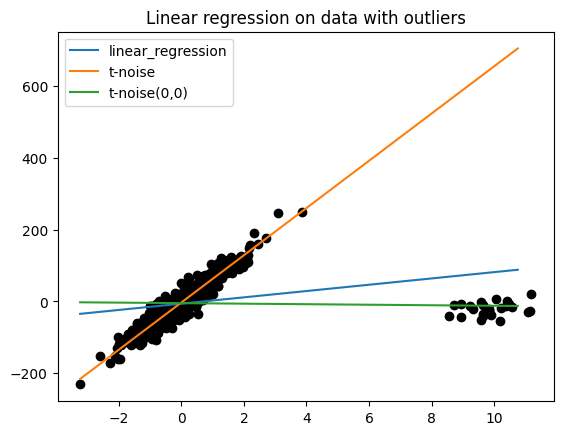

In [52]:
fit_df["t-noise(0,0)"] = plotline_X[:] * res.x[1] + res.x[0]
fix, ax = plt.subplots()
fit_df.plot(ax=ax)
plt.scatter(X[:, 1], y, c="k")
plt.title("Linear regression on data with outliers");

Впрочем, ничего нового, градиентный метод сошелся в локальный оптимум.

#### Задача со звездочкой 8: Экспоненциальный шум
Придумать и реализовать более умную оптимизацию линейной регрессии с экспоненциальным шумом, чем полным перебором по пространству весов. Правильный ответ должен быть **неотличим на глаз** от предсказаний модели.

In [ ]:
...

#### Задача со звездочкой 9: Эллипс

Вы оказались одни в лесу, и вам очень надо восстановить уравнение эллипса по данным. Как на зло, все что у вас есть - это `sklearn.linear_model.LinearRegression`.

**1 балл.** К счастью, вы знаете что эллипс не абы какой, а с осями, параллельными осям координат. 

**1 балл.** А теперь не знаете. (WARNING: я не уверен в том, что это возможно c `LinearRegression`, но OLS может)

In [53]:
# Правильный ответ
CENTER_X = -5.0
CENTER_Y = 2.0
SCALE_X = 2.0
SCALE_Y = 3.0
ANGLE = np.pi / 6

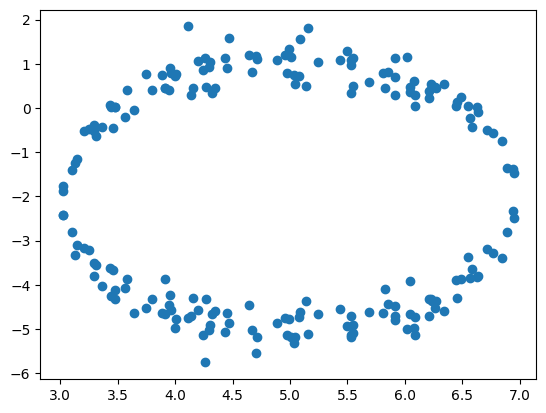

In [54]:
# Генерируем данные
x = np.random.rand(100) * 2 - 1
y_pos = np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y_neg = -np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y = np.hstack([y_pos, y_neg])
x = x * SCALE_X - CENTER_X
y = y * SCALE_Y - CENTER_Y
x = np.hstack([x, x])
data = np.stack([x, y], axis=1)
plt.scatter(data[:, 0], data[:, 1])

---
This notebook is based on Nvidia [article](https://github.com/erykml/nvidia_articles/blob/main/robust_regression.ipynb) on robust regression.